In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

/home/rainorangelemon/Documents/tiny-diffusion


/home/rainorangelemon/micromamba/envs/robodiff/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [1]:
# run the following command in the tmux
# !python ddpm.py --experiment_name composition_product_1 --dataset composition_product_1 --input_embedding identity --hidden_layers 4 --num_epochs 1000
# !python ddpm.py --experiment_name composition_product_2 --dataset composition_product_2 --input_embedding identity --hidden_layers 4 --num_epochs 1000

python: can't open file '/home/rainorangelemon/Documents/tiny-diffusion/notebooks/ddpm.py': [Errno 2] No such file or directory


python: can't open file '/home/rainorangelemon/Documents/tiny-diffusion/notebooks/ddpm.py': [Errno 2] No such file or directory


In [4]:
import torch
import ddpm
model_1 = ddpm.MLP(
    hidden_layers=4,
    input_emb='identity')

model_2 = ddpm.MLP(
    hidden_layers=4,
    input_emb='identity')

model_1.load_state_dict(torch.load("exps/composition_product_1/model.pth"))
model_2.load_state_dict(torch.load("exps/composition_product_2/model.pth"))

<All keys matched successfully>

In [15]:
from tqdm.auto import tqdm
import numpy as np
eval_batch_size = 1000
num_timesteps = 50
plot_step = 5
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 2)
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []
for i, t in enumerate(tqdm(timesteps)):
    for _ in range(20):
        t_tensor = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
        with torch.no_grad():
            residual = (model_1(sample, t_tensor) + model_2(sample, t_tensor)) / 2
        sample = noise_scheduler.step(residual, t_tensor[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.numpy())
        steps.append(i + 1)

  8%|▊         | 4/50 [00:00<00:01, 31.28it/s]

100%|██████████| 50/50 [00:01<00:00, 32.64it/s]


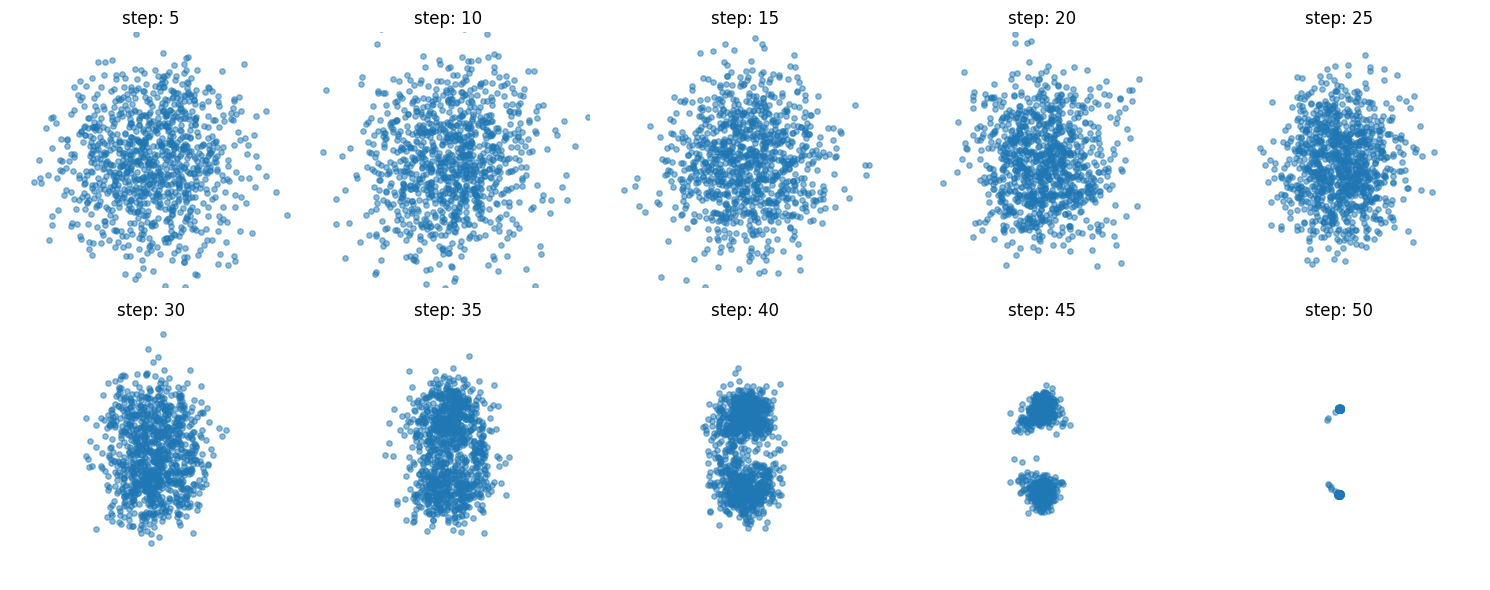

In [16]:
import matplotlib.pyplot as plt
import math
num_cols = 5
num_rows = math.ceil(len(samples) / num_cols)
fig = plt.figure(figsize=(15, 6))
for i, sample in enumerate(samples):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
    plt.title(f"step: {steps[i]}")
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.axis("off")
fig.tight_layout()
plt.show()